In [1]:
## 数据工具包
import numpy as np
import pandas as pd
from tqdm import tqdm

## 字符串处理工具包
import string
import re
import gensim
from collections import Counter
import pickle
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.preprocessing import text, sequence 

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from functools import partial

import os 
import gc
from scipy.sparse import vstack  
import time
import datetime

import joblib

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
import seaborn as sns 
%matplotlib inline

In [2]:
from tqdm import tqdm
from tqdm import tqdm_notebook

path ='./input/'
for i in tqdm(range(1,26)):
    if i < 10:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-0' + str(i) + '.csv')
    else:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-' + str(i) + '.csv')
    if i== 1:
        data = train_tmp
    else:
        data = pd.concat([data, train_tmp],axis=0,ignore_index=True) 
        
Metro_roadMap = pd.read_csv(path + 'Metro_roadMap.csv')

test_A_record = pd.read_csv(path + 'Metro_testA/testA_record_2019-01-28.csv') 
test_A_submit = pd.read_csv(path + 'Metro_testA/testA_submit_2019-01-29.csv') 

data = pd.concat([data, test_A_record],axis=0,ignore_index=True)

100%|██████████| 25/25 [05:13<00:00, 12.55s/it]


In [3]:
def trans_time_10_minutes(x):
    x_split = x.split(':')
    x_part1 = x_split[0]
    x_part2 = int(x_split[1]) // 10
    if x_part2 == 0:
        x_part2 = '00'
    else:
        x_part2 = str(x_part2 * 10)
    return x_part1 + ':' + x_part2 + ':00'

In [4]:
data['time'] = pd.to_datetime(data['time'])
data['time_10_minutes'] = data['time'].astype(str).apply(lambda x: trans_time_10_minutes(x))

In [5]:
data_inNums = data[data.status == 1].groupby(['stationID','time_10_minutes']).size().to_frame('inNums').reset_index()
data_inNums.head() 

,stationID,time_10_minutes,inNums
0,0,2019-01-01 05:30:00,1
1,0,2019-01-01 05:40:00,4
2,0,2019-01-01 05:50:00,3
3,0,2019-01-01 06:00:00,17
4,0,2019-01-01 06:10:00,21


In [6]:
data_outNums = data[data.status == 0].groupby(['stationID','time_10_minutes']).size().to_frame('outNums').reset_index()
data_outNums.head() 

,stationID,time_10_minutes,outNums
0,0,2019-01-01 05:50:00,1
1,0,2019-01-01 06:20:00,1
2,0,2019-01-01 06:30:00,49
3,0,2019-01-01 06:40:00,48
4,0,2019-01-01 06:50:00,25


In [7]:
stationIDs = test_A_submit['stationID'].unique()
times = [] 
days = [i for i in range(1,26)] + [28, 29]
for day in days: 
    if day < 10:
        day_str = '0' + str(day)
    else:
        day_str = str(day)
    for hour in range(24):
        if hour < 10:
            hour_str = '0' + str(hour)
        else:
            hour_str = str(hour)
        for minutes in range(6):
            if minutes == 0:
                minutes_str = '0' + str(minutes)
            else:
                minutes_str = str(minutes * 10) 
            times.append('2019-01-' + day_str + ' ' + hour_str +':' + minutes_str + ':00')

# 求笛卡儿积
from itertools import product
stationids_by_times = list(product(stationIDs, times))
# 构建新的数据集
df_data = pd.DataFrame()
df_data['stationID'] = np.array(stationids_by_times)[:,0]
df_data['startTime'] = np.array(stationids_by_times)[:,1]
df_data = df_data.sort_values(['stationID','startTime'])
df_data['endTime'] = df_data.groupby('stationID')['startTime'].shift(-1).values

In [8]:
df_data

,stationID,startTime,endTime
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00
...,...,...,...
38875,9,2019-01-29 23:10:00,2019-01-29 23:20:00
38876,9,2019-01-29 23:20:00,2019-01-29 23:30:00
38877,9,2019-01-29 23:30:00,2019-01-29 23:40:00
38878,9,2019-01-29 23:40:00,2019-01-29 23:50:00


In [9]:
def filltime(x):
    x_split = x.split(' ')[0].split('-')
    x_part1_1 = x_split[0] +'-'+x_split[1]+'-'
    x_part1_2 = int(x_split[2]) + 1
    if x_part1_2 < 10:
        x_part1_2 = '0' + str(x_part1_2)
    else:
        x_part1_2 = str(x_part1_2)
        
    x_part2 = ' 00:00:00'
    return x_part1_1 + x_part1_2 + x_part2
# 缺失值时间填充
df_data.loc[df_data.endTime.isnull(), 'endTime']  = \
df_data.loc[df_data.endTime.isnull(), 'startTime'].apply(lambda x: filltime(x)) 
df_data['stationID'] = df_data['stationID'].astype(int)

In [10]:
df_data

,stationID,startTime,endTime
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00
...,...,...,...
38875,9,2019-01-29 23:10:00,2019-01-29 23:20:00
38876,9,2019-01-29 23:20:00,2019-01-29 23:30:00
38877,9,2019-01-29 23:30:00,2019-01-29 23:40:00
38878,9,2019-01-29 23:40:00,2019-01-29 23:50:00


In [11]:
data_inNums.rename(columns={'time_10_minutes':'startTime'}, inplace=True)
data_outNums.rename( columns={'time_10_minutes':'startTime'}, inplace=True)

df_data = df_data.merge(data_inNums , on=['stationID', 'startTime'], how='left')
df_data = df_data.merge(data_outNums, on=['stationID', 'startTime'], how='left')
df_data['inNums']  = df_data['inNums'].fillna(0)
df_data['outNums'] = df_data['outNums'].fillna(0)

In [12]:
# 时间相关特征
df_data['time'] = pd.to_datetime(df_data['startTime'])
df_data['day'] = df_data['time'].dt.day  
df_data['hours_in_day'] = df_data['time'].dt.hour 
df_data['day_of_week'] = df_data['time'].dt.dayofweek 
df_data['ten_minutes_in_day'] = df_data['hours_in_day'] * 6 + df_data['time'].dt.minute // 10 
del df_data['time']

In [13]:
df_data

,stationID,startTime,endTime,inNums,outNums,day,hours_in_day,day_of_week,ten_minutes_in_day
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00,0.0,0.0,1,0,1,0
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00,0.0,0.0,1,0,1,1
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00,0.0,0.0,1,0,1,2
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00,0.0,0.0,1,0,1,3
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00,0.0,0.0,1,0,1,4
...,...,...,...,...,...,...,...,...,...
314923,9,2019-01-29 23:10:00,2019-01-29 23:20:00,0.0,0.0,29,23,1,139
314924,9,2019-01-29 23:20:00,2019-01-29 23:30:00,0.0,0.0,29,23,1,140
314925,9,2019-01-29 23:30:00,2019-01-29 23:40:00,0.0,0.0,29,23,1,141
314926,9,2019-01-29 23:40:00,2019-01-29 23:50:00,0.0,0.0,29,23,1,142


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


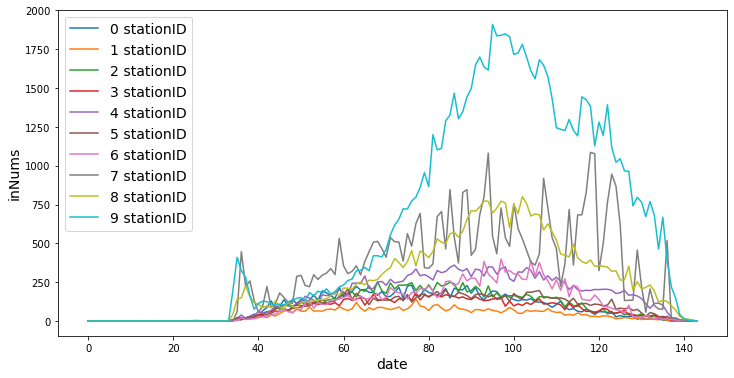

In [14]:
tmp = df_data[df_data.day==1]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[12,6])
plt.ylabel('inNums',fontsize=14)
plt.xlabel('date',fontsize=14)
# plt.title('inNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'inNums'], label = str(i)+' stationID' )
    
plt.legend(fontsize=14)
plt.savefig("10_inNums_of_stationID_1.svg", format="svg")

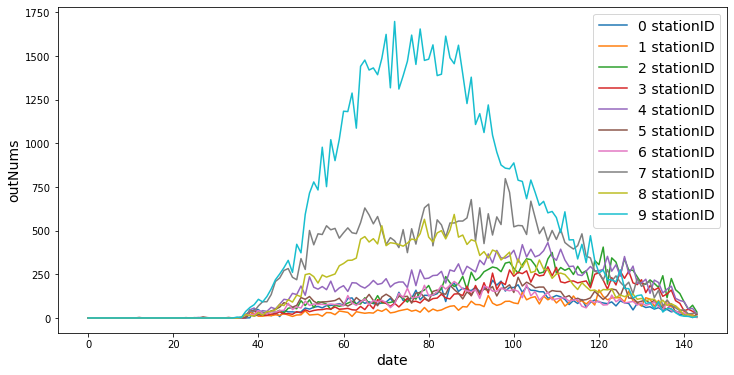

In [15]:
tmp = df_data[df_data.day==1]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[12,6])
plt.ylabel('outNums',fontsize=14)
plt.xlabel('date',fontsize=14)
# plt.title('outNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'outNums'], label = str(i)+' stationID' )
    
plt.legend(fontsize=14)
plt.savefig("10_outNums_of_stationID_2.svg", format="svg")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


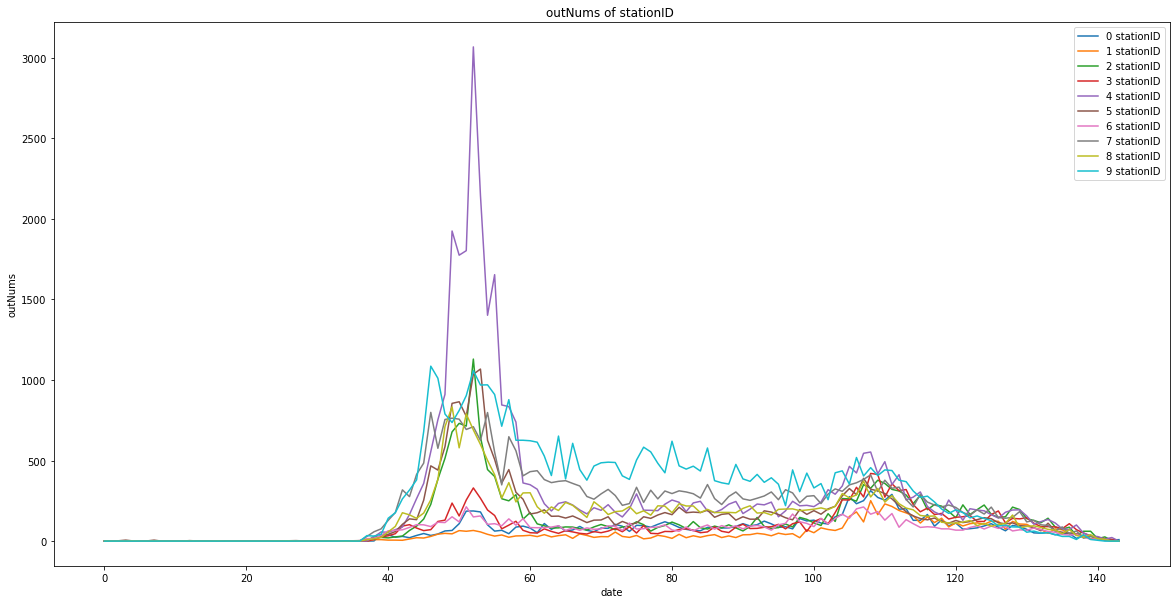

In [16]:
tmp = df_data[df_data.day==3]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[20,10])
plt.ylabel('outNums')
plt.xlabel('date')
plt.title('outNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'outNums'], label = str(i)+' stationID' )
    
plt.legend()
plt.show()

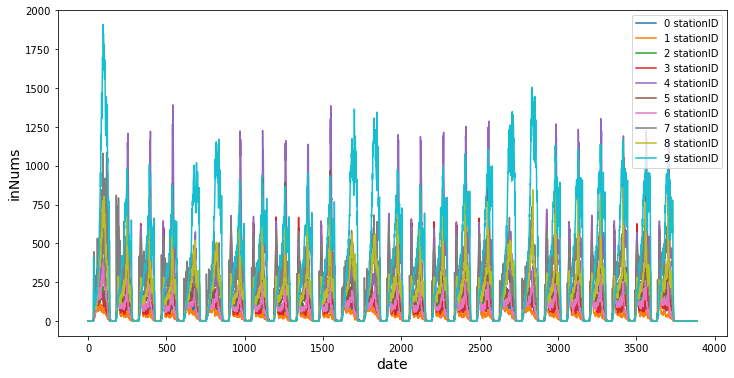

In [17]:
tmp = df_data[df_data.day>=1]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[12,6])
plt.ylabel('inNums',fontsize=14)
plt.xlabel('date',fontsize=14)
# plt.title('inNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'inNums'], label = str(i)+' stationID' )
    
plt.legend()
plt.savefig("10_inNums_of_stationID.svg", format="svg")

In [18]:
Metro_roadMap

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,79,80
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
77,77,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
78,78,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
79,79,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [19]:
Metro_roadMap['adja'] = Metro_roadMap[[str(i) for i in range(81)]].apply(lambda x: x.sum()).values

In [20]:
Metro_roadMap.sort_values('adja')

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,72,73,74,75,76,77,78,79,80,adja
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34,34,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
33,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
66,66,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
67,67,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
46,46,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,4
51,51,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
5,5,0,0,0,0,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,4


In [21]:
Metro_roadMap[[str(i) for i in range(81)]].apply(lambda x: x.sum())

0     1
1     2
2     2
3     2
4     2
     ..
76    2
77    2
78    2
79    2
80    2
Length: 81, dtype: int64

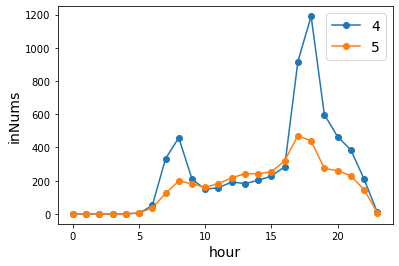

In [22]:
tmp = df_data.loc[(df_data.day.isin([4,5]))]
tmp.loc[tmp.stationID == 4].pivot_table(index='hours_in_day',\
                                        columns='day',values='inNums').plot(style='o-')

plt.ylabel('inNums',fontsize=14)
plt.xlabel('hour',fontsize=14)
plt.legend(fontsize=14)
plt.savefig("10_inNums_of_day45.svg", format="svg")

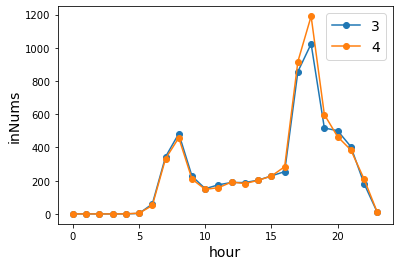

In [23]:
tmp = df_data.loc[(df_data.day.isin([3,4]))]
tmp.loc[tmp.stationID == 4].pivot_table(index='hours_in_day',\
                                        columns='day',values='inNums').plot(style='o-')

plt.ylabel('inNums',fontsize=14)
plt.xlabel('hour',fontsize=14)
plt.legend(fontsize=14)
plt.savefig("10_inNums_of_day34.svg", format="svg")

In [24]:
df_data.loc[(df_data.day.isin([1,2,3,4]))]

,stationID,startTime,endTime,inNums,outNums,day,hours_in_day,day_of_week,ten_minutes_in_day
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00,0.0,0.0,1,0,1,0
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00,0.0,0.0,1,0,1,1
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00,0.0,0.0,1,0,1,2
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00,0.0,0.0,1,0,1,3
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00,0.0,0.0,1,0,1,4
...,...,...,...,...,...,...,...,...,...
311611,9,2019-01-04 23:10:00,2019-01-04 23:20:00,16.0,11.0,4,23,4,139
311612,9,2019-01-04 23:20:00,2019-01-04 23:30:00,8.0,20.0,4,23,4,140
311613,9,2019-01-04 23:30:00,2019-01-04 23:40:00,0.0,0.0,4,23,4,141
311614,9,2019-01-04 23:40:00,2019-01-04 23:50:00,0.0,0.0,4,23,4,142


In [25]:
df_data.loc[df_data.day==1, 'day'] = '元旦'

In [39]:
import matplotlib
font_list = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

for i in font_list:
    print(i)

.Aqua Kana
.Arabic UI Display
.Arabic UI Text
.Helvetica Neue DeskInterface
.Keyboard
.New York
.New York
.SF Compact Display
.SF Compact Rounded
.SF Compact Text
.SF Compact Text
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Mono
.SF NS Mono
.SF NS Rounded
.SF NS Text Condensed
.SF NS Text Condensed
.SF NS Text Condensed
.SF NS Text Condensed
.SF NS Text Condensed
.SF NS Text Condensed
Al Bayan
Al Nile
Al Tarikh
American Typewriter
Andale Mono
Apple Braille
Apple Braille
Apple Braille
Apple Braille
Apple Braille
Apple Chancery
Apple SD Gothic Neo
Apple Symbols
AppleGothic
AppleMyungjo
Arial
Arial
Arial
Arial
Arial Black
Arial Hebrew
Arial Narrow
Arial Narrow
Arial Narrow
Arial Narrow
Arial Rounded MT Bold
Arial Unicode MS
Arial Unicode MS
Athelas
Avenir
Avenir Next
Avenir Next Condensed
Ayuthaya
Baghda

In [40]:
plt.rcParams['font.sans-serif'] = ['Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

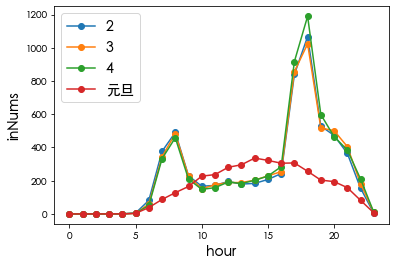

In [41]:
tmp = df_data.loc[(df_data.day.isin(['元旦',2,3,4]))]
tmp.loc[tmp.stationID == 4].pivot_table(index='hours_in_day',\
                                        columns='day',values='inNums').plot(style='o-')

plt.ylabel('inNums',fontsize=14)
plt.xlabel('hour',fontsize=14)
plt.legend(fontsize=14)
plt.savefig("10_inNums_of_day1234.svg", format="svg")

In [81]:
df_data[df_data.stationID==4].groupby(['day'])['outNums'].sum()

day
1     24016.0
2     38615.0
3     38065.0
4     38791.0
5     25276.0
6     21186.0
7     37678.0
8     37507.0
9     36826.0
10    37480.0
11    38778.0
12    25621.0
13    22081.0
14    38860.0
15    37295.0
16    38719.0
17    39327.0
18    41707.0
19    27112.0
20    23881.0
21    40142.0
22    39285.0
23    39348.0
24    39737.0
25    39597.0
28    36844.0
29        0.0
Name: outNums, dtype: float64

In [82]:
df_data

,stationID,startTime,endTime,inNums,outNums,day,hours_in_day,day_of_week,ten_minutes_in_day
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00,0.0,0.0,1,0,1,0
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00,0.0,0.0,1,0,1,1
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00,0.0,0.0,1,0,1,2
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00,0.0,0.0,1,0,1,3
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00,0.0,0.0,1,0,1,4
...,...,...,...,...,...,...,...,...,...
314923,9,2019-01-29 23:10:00,2019-01-29 23:20:00,0.0,0.0,29,23,1,139
314924,9,2019-01-29 23:20:00,2019-01-29 23:30:00,0.0,0.0,29,23,1,140
314925,9,2019-01-29 23:30:00,2019-01-29 23:40:00,0.0,0.0,29,23,1,141
314926,9,2019-01-29 23:40:00,2019-01-29 23:50:00,0.0,0.0,29,23,1,142


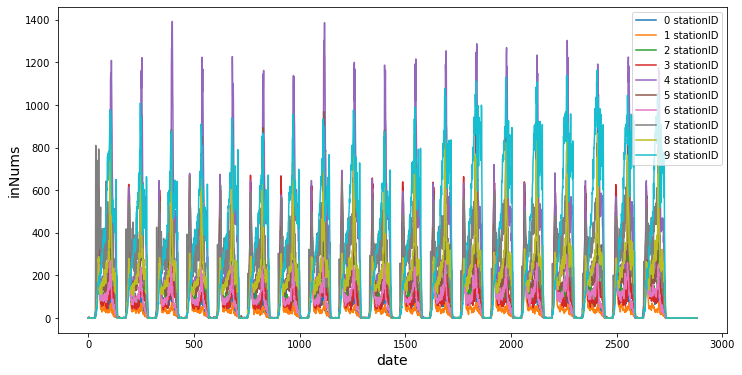

In [52]:
# 剔除与测试集分布差异大的日期
df_data = df_data.loc[((df_data.day_of_week < 5) & (df_data.day != 1))].copy()
# 保留日期
retain_days = list(df_data.day.unique())
# 重新计算rank，方便我们后续提取特征
days_relative = {} 
for i,d in enumerate(retain_days):
    days_relative[d] = i + 1

df_data['days_relative'] = df_data['day'].map(days_relative)

#### 可视化代码 ####
dt = [r for r in range(df_data.loc[df_data.stationID==0, 
    'ten_minutes_in_day'].shape[0])]
fig = plt.figure(1,figsize=[12,6])
plt.ylabel('inNums',fontsize=14)
plt.xlabel('date',fontsize=14)

for i in range(0,10):
    plt.plot(dt, df_data.loc[df_data.stationID==i, 'inNums'], label = str(i)+' stationID' )  
plt.legend()

# 生成矢量图
plt.savefig("inNums_of_stationID.svg", format="svg")